### This notebook calculates mutational density of genes of H37Rv from SNVs & INDELs

In [4]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
%matplotlib inline

In [5]:
#import necessary packages
import vcf
import os
import pandas as pd
import numpy as np

from itertools import compress
import ast
import itertools
import time

import Bio
from Bio.Alphabet import IUPAC
from Bio.Blast.Applications import NcbiblastnCommandline
from Bio.Blast import NCBIXML
from Bio.Seq import Seq
from Bio.SeqRecord import SeqRecord
from Bio.SeqFeature import SeqFeature, FeatureLocation
from Bio import pairwise2
from Bio import SeqIO
from Bio.Graphics import GenomeDiagram
from Bio.SeqUtils import GC

from Bio.Align.Applications import MuscleCommandline
from StringIO import StringIO
from Bio import AlignIO
from Bio.Align import AlignInfo
from Bio.Seq import MutableSeq
from Bio import pairwise2
from shutil import copy
import subprocess

import matplotlib.pyplot as plt
import pickle
import scipy.stats
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib as mpl
from matplotlib import gridspec

#for exporting to Adobe Illustrator
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42

In [6]:
plt.style.use('ggplot')
plt.rcParams['lines.linewidth']=0
plt.rcParams['axes.facecolor']='1.0'
plt.rcParams['xtick.color']='black'
plt.rcParams['axes.grid']=False
plt.rcParams['axes.edgecolor']='black'
plt.rcParams['grid.color']= '1.0'
plt.rcParams.update({'font.size': 10})
plt.rc('font', family='serif')

####################################################################################################################################################################################

## [1] Get H37Rv Reference Positions for SNPs that were filtered out from Genotypes Matrix

####################################################################################################################################################################################

#### Load in dataframes with SNPs that were dropped in different filtering steps in constructing the Genotypes Matrix

These SNP sites will be excluded from the analysis

In [7]:
## dropped_SNPs_filter_1 = pd.read_pickle('/n/data1/hms/dbmi/farhat/Roger/homoplasy_project/rolling_DB_scrape/Genotypes_Filtered/SNP_sites_dropped/1_dropped_SNPs_annotation_low_EBR_score.pkl')
with open('/n/data1/hms/dbmi/farhat/Roger/homoplasy_project/rolling_DB_scrape/Genotypes/H37Rv_sites_with_low_EBR_to_drop.pkl', 'rb') as f:
    dropped_SNPs_filter_1 = pickle.load(f)
## dropped_SNPs_filter_2 = pd.read_pickle('/n/data1/hms/dbmi/farhat/Roger/homoplasy_project/rolling_DB_scrape/Genotypes_Filtered/SNP_sites_dropped/2_dropped_SNPs_annotation_MGE_region.pkl')
dropped_SNPs_filter_3 = pd.read_pickle('/n/data1/hms/dbmi/farhat/Roger/homoplasy_project/rolling_DB_scrape/Genotypes_Filtered/SNP_sites_dropped/3_dropped_SNPs_annotation_calls_missing_10perc_isolates.pkl')
dropped_SNPs_filter_4 = pd.read_pickle('/n/data1/hms/dbmi/farhat/Roger/homoplasy_project/rolling_DB_scrape/Genotypes_Filtered/SNP_sites_dropped/4_dropped_SNPs_annotation_overlapping_genes.pkl')

In [8]:
len(dropped_SNPs_filter_1)

169630

In [9]:
dropped_SNPs_filter_3.head(n=2)

,pos,ref,alt
0,29,C,[G]
1,31,A,"[C, G]"


In [10]:
dropped_SNPs_filter_3.shape

(31215, 3)

In [11]:
dropped_SNPs_filter_4.head(n=2)

,pos,ref,alt
7199,60414,C,[T]
8910,77620,C,[G]


In [12]:
dropped_SNPs_filter_4.shape

(933, 3)

#### combine all of the H37Rv Reference Positions that were dropped into one set

In [13]:
H37Rv_positions_to_exclude = set(dropped_SNPs_filter_1 + list(dropped_SNPs_filter_3.pos) + list(dropped_SNPs_filter_4.pos))

In [14]:
len(H37Rv_positions_to_exclude)

201767

####################################################################################################################################################################################

## [2] *Function* to get length of coding sequence for each gene (after excluding dropped sites)

####################################################################################################################################################################################

In [15]:
reference_genome_annotation = pd.read_csv('/n/data1/hms/dbmi/farhat/Roger/inhost_TB_dynamics_project/H37Rv/h37rv_genome_summary.txt', '\t').set_index('name')

In [16]:
def get_nucleotide_length(gene_i):

    #Identify all bases on H37Rv gene sequence that affect a coding sequence
    gene_id_info = reference_genome_annotation.loc[gene_i , :]

    chrom_start = gene_id_info.chromStart
    chrom_end = gene_id_info.chromEnd

    #find the position of the first base relative to H37Rv in 5' -> 3'
    H37Rv_start = min(chrom_start , chrom_end)
    H37Rv_end = max(chrom_start , chrom_end)

    #make a list of all corresponding H37Rv Reference Positions for gene_i
    coding_bases = range(H37Rv_start+1 , H37Rv_end+1)

    #Filter out any positions that were dropped per (1) low EBR scores, (2) located in MGE region, (3) low SNP base quality across isolates [> 10% isolates had missing calls] or (4) located in overlapping gene region
    coding_bases = np.sort(list(set(coding_bases) - H37Rv_positions_to_exclude))

    #keep number of positions we are analyzing for this gene to normalize by gene length
    num_coding_positions = len(coding_bases) 
    
    return num_coding_positions

In [17]:
get_nucleotide_length('Rv0667')

3519

####################################################################################################################################################################################

## [3] SNVs: Get gene-wide Syn & NSyn *mutation event* scores

####################################################################################################################################################################################

In [18]:
#load in SNPs
all_homoplasic_SNPs = pd.read_pickle('/n/data1/hms/dbmi/farhat/Roger/homoplasy_project/CSV_files/homoplasies_detected_in_global_lineages/SNP homoplasies from SNPPar/homoplasy_count_across_lineages.pkl')

In [19]:
all_homoplasic_SNPs.shape

(834981, 20)

Exclude Mobile Genetic Elements

In [20]:
all_homoplasic_SNPs = all_homoplasic_SNPs[all_homoplasic_SNPs.gene_category != 'Mobile Genetic Element']

In [21]:
all_homoplasic_SNPs.shape

(834971, 20)

### SNPs

In [22]:
all_homoplasic_SNPs.head()

,pos,ref,alt,minor,gene_id,gene_pos,gene_category,SNP_type,AA_change,1,2,3,4A,4B,4C,5,6,total,gene_name,num_isolates_alt
0,2155168.0,C,G,G,Rv1908c,944,Antibiotic Resistance,N,S315T,203,408,297,306,310,179,8,6,1717,katG,8066
1,761155.0,C,T,T,Rv0667,1349,Antibiotic Resistance,N,S450L,75,415,199,222,311,173,8,3,1406,rpoB,5706
2,781687.0,A,G,G,Rv0682,128,Antibiotic Resistance,N,K43R,37,463,102,65,53,51,6,2,779,rpsL,3509
4,4247429.0,A,G,G,Rv3795,916,Antibiotic Resistance,N,M306V,32,406,67,76,99,60,2,1,743,embB,2102
6,7582.0,A,G,G,Rv0006,281,Antibiotic Resistance,N,D94G,10,320,67,77,53,25,0,0,552,gyrA,844


In [23]:
all_homoplasic_SNPs.tail()

,pos,ref,alt,minor,gene_id,gene_pos,gene_category,SNP_type,AA_change,1,2,3,4A,4B,4C,5,6,total,gene_name,num_isolates_alt
833683,1489655.0,A,G,G,Rv1325c,311,PE/PPE,N,I104T,1,0,0,0,0,0,0,0,1,PE_PGRS24,1
833686,1489661.0,A,G,G,Rv1325c,305,PE/PPE,N,L102P,0,0,0,1,0,0,0,0,1,PE_PGRS24,1
833688,1489670.0,T,C,C,Rv1325c,296,PE/PPE,N,E99G,0,0,1,0,0,0,0,0,1,PE_PGRS24,1
833690,1489671.0,C,A,A,Rv1325c,295,PE/PPE,N,E99*,0,0,0,1,0,0,0,0,1,PE_PGRS24,1
833691,1489671.0,C,T,T,Rv1325c,295,PE/PPE,N,E99K,0,1,0,0,0,0,0,0,1,PE_PGRS24,12


In [24]:
# get gene list
gene_ids_list = list(set(all_homoplasic_SNPs.gene_id))
gene_ids_list = [x for x in gene_ids_list if str(x) != 'nan'] # get rid of nan 
gene_ids_list = [x for x in gene_ids_list if '_' not in x] # get rid of intergenic regions

# get gene symbols as a series (index gene id, value gene symbol)
gene_id_and_symbol_list = [[gene_id , list(all_homoplasic_SNPs[all_homoplasic_SNPs.gene_id == gene_id].gene_name)[0]] for gene_id in gene_ids_list]
gene_id_and_symbol_dict = dict(gene_id_and_symbol_list)
gene_id_and_symbol_series = pd.Series(gene_id_and_symbol_dict , name = 'gene_name')

In [25]:
#number of unique SNVs (not necessarily sites since non bi-allelic SNP sites may have 2 or 3 alternate/mutant alleles)
#iterate through each gene and collect number of Syn & NSyn mutation events and number of unique SNVs
num_unique_SNVs_per_gene = []
num_Syn_ME_per_gene = []
num_NSyn_ME_per_gene = []
nuc_length_per_gene = []

SNV_count_by_gene_df = pd.DataFrame(gene_id_and_symbol_series)

for gene_id in SNV_count_by_gene_df.index:
    all_SNV_ME_for_gene = all_homoplasic_SNPs[all_homoplasic_SNPs.gene_id == gene_id] #get all SNVs that correspond to this gene
    Syn_SNV_ME_for_gene = all_SNV_ME_for_gene[all_SNV_ME_for_gene.SNP_type == 'S'] #set Synonymous mutation events
    NSyn_SNV_ME_for_gene = all_SNV_ME_for_gene[all_SNV_ME_for_gene.SNP_type == 'N'] #set Non-Synonymous mutation events

    num_unique_SNVs_per_gene.append(float(len(all_SNV_ME_for_gene.index))) #number of SNVs identified in gene with at least 1 ME
    
    #get the number of mutation events for all SNVs (even for SNVs that had 1 ME)
    num_Syn_ME_per_gene.append(float(Syn_SNV_ME_for_gene.total.sum()))
    num_NSyn_ME_per_gene.append(float(NSyn_SNV_ME_for_gene.total.sum()))
    
    #get the nucleotide length for each gene (nucleotide reference position sites that weren't dropped through filtering)
    nuc_length_per_gene.append(get_nucleotide_length(gene_id))

#number of unique SNVs detected on gene with at least 1 ME
SNV_count_by_gene_df.loc[: , 'unique_SNV_count'] = num_unique_SNVs_per_gene

#number of mutation events that occurred on gene broken down by functional type
SNV_count_by_gene_df.loc[: , 'Syn_ME_count'] = num_Syn_ME_per_gene
SNV_count_by_gene_df.loc[: , 'NSyn_ME_count'] = num_NSyn_ME_per_gene
SNV_count_by_gene_df.loc[: , 'ME_count'] = SNV_count_by_gene_df.NSyn_ME_count + SNV_count_by_gene_df.Syn_ME_count

#length of nucleotide sequence considered per gene
SNV_count_by_gene_df.loc[: , 'nuc_length'] = nuc_length_per_gene

In [26]:
SNV_count_by_gene_df.head()

,gene_name,unique_SNV_count,Syn_ME_count,NSyn_ME_count,ME_count,nuc_length
Rv0001,dnaA,467.0,162.0,673.0,835.0,1495
Rv0002,dnaN,275.0,105.0,203.0,308.0,1133
Rv0003,recF,281.0,151.0,180.0,331.0,1158
Rv0004,Rv0004,213.0,74.0,189.0,263.0,564
Rv0005,gyrB,588.0,276.0,574.0,850.0,2027


In [27]:
np.shape(SNV_count_by_gene_df)

(3899, 6)

#### Keep genes that have at least 1 ME

In [28]:
genes_to_keep = SNV_count_by_gene_df.ME_count >= 1
SNV_count_by_gene_df = SNV_count_by_gene_df[genes_to_keep]

In [29]:
np.shape(SNV_count_by_gene_df)

(3854, 6)

####################################################################################################################################################################################

## [4] INDELs: Get gene-wide inframe & frameshift *mutation event* scores

####################################################################################################################################################################################

### INDELs

In [30]:
#load in INDELs
all_homoplasic_INDELs = pd.read_pickle('/n/data1/hms/dbmi/farhat/Roger/homoplasy_project/CSV_files/homoplasies_detected_in_global_lineages/INDEL homoplasies/homoplasy_count_across_lineages_spacer_4.pkl')

In [31]:
all_homoplasic_INDELs.shape

(46306, 22)

Exclude Mobile Genetic Elements

In [32]:
all_homoplasic_INDELs = all_homoplasic_INDELs[all_homoplasic_INDELs.gene_category != 'Mobile Genetic Element']

In [33]:
all_homoplasic_INDELs.shape

(46305, 22)

In [34]:
all_homoplasic_INDELs.head(n = 5)

,pos,ref,alt,gene_category,gene_name,gene_id,gene_pos,ins_del,INDEL_type,codon_pos,...,1,2,3,4A,4B,4C,5,6,total,num_isolates
47371,4408100,GC,G,Antibiotic Resistance,gid,Rv3919c,103,del,frameshift,35,...,41.0,27.0,51.0,43.0,11.0,29.0,0.0,0.0,202.0,388
47365,4408087,CG,C,Antibiotic Resistance,gid,Rv3919c,116,del,frameshift,39,...,23.0,11.0,35.0,33.0,10.0,18.0,0.0,0.0,130.0,212
47313,4407851,GC,G,Antibiotic Resistance,gid,Rv3919c,352,del,frameshift,118,...,21.0,9.0,40.0,20.0,6.0,19.0,0.0,0.0,115.0,182
25151,2288850,A,ACC,Antibiotic Resistance,pncA,Rv2043c,392,ins,frameshift,131,...,1.0,14.0,6.0,3.0,6.0,2.0,0.0,0.0,32.0,48
47315,4407851,G,GC,Antibiotic Resistance,gid,Rv3919c,352,ins,frameshift,118,...,5.0,1.0,12.0,5.0,7.0,1.0,0.0,0.0,31.0,52


In [35]:
all_homoplasic_INDELs.tail()

,pos,ref,alt,gene_category,gene_name,gene_id,gene_pos,ins_del,INDEL_type,codon_pos,...,1,2,3,4A,4B,4C,5,6,total,num_isolates
46698,4375788,T,TG,PE/PPE,PE36,Rv3893c,208,ins,frameshift,70,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,392
46699,4375794,GT,G,PE/PPE,PE36,Rv3893c,202,del,frameshift,68,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1
46700,4375898,GGC,G,PE/PPE,PE36,Rv3893c,98,del,frameshift,33,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,3
46701,4375911,C,CG,PE/PPE,PE36,Rv3893c,85,ins,frameshift,29,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1
46702,4375988,CA,C,PE/PPE,PE36,Rv3893c,8,del,frameshift,3,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,8


In [36]:
#get gene list
gene_ids_list = list(set(all_homoplasic_INDELs.gene_id))
gene_ids_list = [x for x in gene_ids_list if str(x) != 'nan'] #get rid of nan 
gene_ids_list = [x for x in gene_ids_list if '_' not in x] #get rid of intergenic regions

#get gene symbols as a series (index gene id, value gene symbol)
gene_id_and_symbol_list = [[gene_id , list(all_homoplasic_INDELs[all_homoplasic_INDELs.gene_id == gene_id].gene_name)[0]] for gene_id in gene_ids_list]
gene_id_and_symbol_dict = dict(gene_id_and_symbol_list)
gene_id_and_symbol_series = pd.Series(gene_id_and_symbol_dict , name = 'gene_name')

In [37]:
#number of unique INDELs (not necessarily sites since non bi-allelic SNP sites may have 2 or 3 alternate/mutant alleles)
#iterate through each gene and collect number of inframe & frameshift mutation events and number of unique INDELs
num_unique_INDELs_per_gene = []
num_inframe_ME_per_gene = []
num_frameshift_ME_per_gene = []
nuc_length_per_gene = []

INDEL_count_by_gene_df = pd.DataFrame(gene_id_and_symbol_series)

for gene_id in INDEL_count_by_gene_df.index:
    all_INDEL_ME_for_gene = all_homoplasic_INDELs[all_homoplasic_INDELs.gene_id == gene_id] #get all INDELs that correspond to this gene
    inframe_INDEL_ME_for_gene = all_INDEL_ME_for_gene[all_INDEL_ME_for_gene.INDEL_type == 'inframe'] #set inframe mutation events
    frameshift_INDEL_ME_for_gene = all_INDEL_ME_for_gene[all_INDEL_ME_for_gene.INDEL_type == 'frameshift'] #set frameshift mutation events

    num_unique_INDELs_per_gene.append(float(len(all_INDEL_ME_for_gene.index))) #number of INDELs identified in gene with at least 1 ME
    
    #get the number of mutation events for all INDELs (even for SNVs that had 1 ME)
    num_inframe_ME_per_gene.append(float(inframe_INDEL_ME_for_gene.total.sum()))
    num_frameshift_ME_per_gene.append(float(frameshift_INDEL_ME_for_gene.total.sum()))
    
    #get the nucleotide length for each gene (nucleotide reference position sites that weren't dropped through filtering)
    nuc_length_per_gene.append(get_nucleotide_length(gene_id))

#number of unique INDELs detected on gene with at least 1 ME
INDEL_count_by_gene_df.loc[: , 'unique_INDEL_count'] = num_unique_INDELs_per_gene

#number of mutation events that occurred on gene broken down by functional type
INDEL_count_by_gene_df.loc[: , 'inframe_ME_count'] = num_inframe_ME_per_gene
INDEL_count_by_gene_df.loc[: , 'frameshift_ME_count'] = num_frameshift_ME_per_gene
INDEL_count_by_gene_df.loc[: , 'ME_count'] = INDEL_count_by_gene_df.inframe_ME_count + INDEL_count_by_gene_df.frameshift_ME_count

#length of nucleotide sequence considered per gene
INDEL_count_by_gene_df.loc[: , 'nuc_length'] = nuc_length_per_gene

In [38]:
INDEL_count_by_gene_df.head()

,gene_name,unique_INDEL_count,inframe_ME_count,frameshift_ME_count,ME_count,nuc_length
Rv0001,dnaA,1.0,1.0,0.0,1.0,1495
Rv0005,gyrB,2.0,19.0,0.0,19.0,2027
Rv0007,Rv0007,7.0,5.0,6.0,11.0,914
Rv0008c,Rv0008c,17.0,2.0,18.0,20.0,438
Rv0009,ppiA,3.0,0.0,3.0,3.0,549


In [39]:
np.shape(INDEL_count_by_gene_df)

(3381, 6)

#### Keep genes that have at least 1 ME

In [40]:
genes_to_keep = INDEL_count_by_gene_df.ME_count >= 1
INDEL_count_by_gene_df = INDEL_count_by_gene_df[genes_to_keep]

In [41]:
np.shape(INDEL_count_by_gene_df)

(3381, 6)

####################################################################################################################################################################################

## [5] Plot *mutational density* per gene for SNVs & INDELs

####################################################################################################################################################################################

## [5.1] SNVs

Normalize number of mutations by the lengths of the gene

In [42]:
SNV_count_by_gene_df.loc[: , 'mut_density'] = SNV_count_by_gene_df.ME_count / SNV_count_by_gene_df.nuc_length

Get list for the average of the first/last coordinates for the coding sequence of the gene

In [43]:
gene_avg_coords = []

for gene_id in SNV_count_by_gene_df.index:

    #Identify all bases on H37Rv gene sequence that affect a coding sequence
    gene_id_info = reference_genome_annotation.loc[gene_id , :]

    chrom_start = gene_id_info.chromStart
    chrom_end = gene_id_info.chromEnd
    
    gene_avg_coords.append((float(chrom_start) + float(chrom_end)) / 2.0)
    
SNV_count_by_gene_df.loc[: , 'avg_pos_coords'] = gene_avg_coords

In [44]:
SNV_count_by_gene_df.head()

,gene_name,unique_SNV_count,Syn_ME_count,NSyn_ME_count,ME_count,nuc_length,mut_density,avg_pos_coords
Rv0001,dnaA,467.0,162.0,673.0,835.0,1495,0.558528,762.0
Rv0002,dnaN,275.0,105.0,203.0,308.0,1133,0.271845,2655.5
Rv0003,recF,281.0,151.0,180.0,331.0,1158,0.285838,3858.0
Rv0004,Rv0004,213.0,74.0,189.0,263.0,564,0.466312,4715.0
Rv0005,gyrB,588.0,276.0,574.0,850.0,2027,0.419339,6253.0


In [45]:
def SNV_mut_dens(ax):

    ax.scatter(SNV_count_by_gene_df.avg_pos_coords , SNV_count_by_gene_df.mut_density , color = '0.1' , edgecolor='white', linewidth=0.0, s = 24 , alpha = 0.7)

    ax.set_xlabel('H37Rv Reference Position (bp)\n(N={0} Genes)'.format(str(np.shape(SNV_count_by_gene_df)[0])), fontsize = 8, color = 'k')
    ax.set_ylabel('Mutational Density per Gene (SNVs)' , fontsize = 8, color = 'k')

    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.grid(False)
    ax.set_xlim(-40000, 4440000)
    ax.set_ylim(-0.10, SNV_count_by_gene_df.mut_density.max()+0.065)
    ax.tick_params(labelcolor = 'k')

    ax.tick_params(axis='y', which='major', labelsize=8 , labelcolor = 'k')
    ax.tick_params(axis='x', which='major', labelsize=8 , labelcolor = 'k')

In [46]:
#convert datatypes from float > int
convert_dict = {'unique_SNV_count':int, 'Syn_ME_count':int, 'NSyn_ME_count':int, 'ME_count':int}
SNV_count_by_gene_df = SNV_count_by_gene_df.astype(convert_dict)

In [47]:
SNV_count_by_gene_df.sort_values(by = 'mut_density' , ascending = False).head(n = 25)

,gene_name,unique_SNV_count,Syn_ME_count,NSyn_ME_count,ME_count,nuc_length,mut_density,avg_pos_coords
Rv3467,Rv3467,7,2,397,399,44,9.068182,3884440.0
Rv1198,esxL,70,708,1083,1791,275,6.512727,1341147.5
Rv3466,Rv3466,30,643,148,791,124,6.379032,3883858.5
Rv0515,Rv0515,13,5,344,349,73,4.780822,607306.0
Rv2043c,pncA,506,56,2229,2285,561,4.073084,2288960.5
Rv0336,Rv0336,20,6,316,322,82,3.926829,400947.0
Rv2346c,esxO,78,569,380,949,278,3.413669,2626029.5
Rv0095c,Rv0095c,76,708,93,801,247,3.242915,105009.5
Rv0682,rpsL,68,56,1153,1209,375,3.224000,781746.5
Rv1196,PPE18,284,1434,1641,3075,1042,2.951056,1339936.0


## [5.2] INDELs

Normalize number of mutations by the lengths of the gene

In [48]:
INDEL_count_by_gene_df.loc[: , 'mut_density'] = INDEL_count_by_gene_df.ME_count / INDEL_count_by_gene_df.nuc_length

Get list for the average of the first/last coordinates for the coding sequence of the gene

In [49]:
gene_avg_coords = []

for gene_id in INDEL_count_by_gene_df.index:

    #Identify all bases on H37Rv gene sequence that affect a coding sequence
    gene_id_info = reference_genome_annotation.loc[gene_id , :]

    chrom_start = gene_id_info.chromStart
    chrom_end = gene_id_info.chromEnd
    
    gene_avg_coords.append((float(chrom_start) + float(chrom_end)) / 2.0)
    
INDEL_count_by_gene_df.loc[: , 'avg_pos_coords'] = gene_avg_coords

In [50]:
INDEL_count_by_gene_df.head()

,gene_name,unique_INDEL_count,inframe_ME_count,frameshift_ME_count,ME_count,nuc_length,mut_density,avg_pos_coords
Rv0001,dnaA,1.0,1.0,0.0,1.0,1495,0.000669,762.0
Rv0005,gyrB,2.0,19.0,0.0,19.0,2027,0.009373,6253.0
Rv0007,Rv0007,7.0,5.0,6.0,11.0,914,0.012035,10370.5
Rv0008c,Rv0008c,17.0,2.0,18.0,20.0,438,0.045662,12092.0
Rv0009,ppiA,3.0,0.0,3.0,3.0,549,0.005464,12741.5


In [51]:
INDEL_count_by_gene_df.shape

(3381, 8)

#### Load in homopolymeric regions from Luca

In [52]:
homopolymeric_regions_from_Luca = pd.read_csv('/n/data1/hms/dbmi/farhat/Roger/homoplasy_project/CSV_files/comparison_with_homopolymeric_regions/homopolymer regions from Luca/list_homopolymers_7bpmore_pure.csv')

In [53]:
homopolymeric_regions_from_Luca.shape

(145, 6)

In [54]:
homopolymeric_regions_from_Luca.head()

,Chromosome,chromStart,chromEnd,polyNT,locus_tag,gene_name
0,NC_000962.3,36470,36477,CCCCCCC,Rv0032,bioF2
1,NC_000962.3,71453,71460,CCCCCCC,Rv0064,Rv0064
2,NC_000962.3,191391,191398,CCCCCCC,Rv0161,Rv0161
3,NC_000962.3,238807,238814,CCCCCCC,Rv0202c,mmpL11
4,NC_000962.3,587728,587735,CCCCCCC,Rv0497,Rv0497


create a filter that seperates genes with an HT and genes without an HT

In [139]:
gene_with_HT_filter = np.array([(gene_i in list(homopolymeric_regions_from_Luca.locus_tag)) for gene_i in INDEL_count_by_gene_df.index])

In [140]:
sum(gene_with_HT_filter)

103

In [142]:
gene_without_HT_filter = np.array([(gene_i not in list(homopolymeric_regions_from_Luca.locus_tag)) for gene_i in INDEL_count_by_gene_df.index])

In [143]:
sum(gene_without_HT_filter)

3278

#### Load SSR regions

In [59]:
SSR_H37Rv_df = pd.read_pickle('/n/data1/hms/dbmi/farhat/Roger/homoplasy_project/CSV_files/simple_sequence_repeat_regions/SSR_H37Rv_2-6bp_at_least_3_repeats.pkl')

In [60]:
SSR_H37Rv_df.head()

,H37Rv_start,H37Rv_end,motif,repeats
0,561,569,CGC,3
1,562,570,GCC,3
2,643,648,AC,3
3,1121,1126,GC,3
4,1408,1413,CA,3


In [61]:
SSR_H37Rv_df.shape

(18316, 4)

annotate each INDEL with gene H37Rv tag if SSR is contained within gene

In [62]:
reference_genome_annotation.head()

,symbol,synonym,length,chromStart,chromEnd,strand,description,chrom,goterms,ecnums,kegg,pathways,cogs,pfams,operons
name,,,,,,,,,,,,,,,
Rv0001,dnaA,NaN,1524,0,1524,+,chromosomal replication initiator protein,chr,NaN,NaN,NaN,NaN,COG:L,"PF00308.10,PF08299.3",dnaA-dnaA
Rv0002,dnaN,NaN,1209,2051,3260,+,DNA polymerase III beta chain,chr,GO:0003887,EC:2.7.7.7,"KEGG:03030,KEGG:00230,KEGG:00240",NaN,COG:L,"PF00712.11,PF02767.8,PF02768.7",dnaN-Rv0004
Rv0003,recF,NaN,1158,3279,4437,+,DNA replication and repair protein,chr,NaN,NaN,NaN,NaN,COG:L,PF02463.11,dnaN-Rv0004
Rv0004,NaN,NaN,564,4433,4997,+,conserved hypothetical protein,chr,NaN,NaN,NaN,NaN,COG:R,PF05258.4,dnaN-Rv0004
Rv0005,gyrB,NaN,2028,5239,7267,+,DNA gyrase subunit B,chr,GO:0003918,EC:5.99.1.3,NaN,NaN,COG:L,"PF00204.17,PF00986.13,PF01751.14,PF02518.18",gyrB-gyrA


In [63]:
SSR_i_genes = []

for SSR_i_start, SSR_i_end in zip(SSR_H37Rv_df.H37Rv_start, SSR_H37Rv_df.H37Rv_end):

    SSR_i_gene_annotation_df = reference_genome_annotation[(reference_genome_annotation.chromStart <= (SSR_i_start-1)) & (reference_genome_annotation.chromEnd >= (SSR_i_end-1))]

    # there is a gene for which this SSR is contained within
    if np.shape(SSR_i_gene_annotation_df)[0] >= 1:

        # iterate through all genes for which SSR is contained within (may be overlapping)
        for i in range(0, np.shape(SSR_i_gene_annotation_df)[0]):
            gene_i = SSR_i_gene_annotation_df.index[i]
            SSR_i_genes.append(gene_i)

In [64]:
# get rid of redundant genes
SSR_i_genes = list(set(SSR_i_genes))

In [65]:
len(SSR_i_genes)

3447

create a filter that seperates genes with an SSR (but not an HT) from genes that have neither an HT or SSR

In [144]:
gene_with_SSR_filter = np.array([( (gene_i in SSR_i_genes) & (gene_i not in list(homopolymeric_regions_from_Luca.locus_tag)) ) for gene_i in INDEL_count_by_gene_df.index])

In [145]:
sum(gene_with_SSR_filter)

2827

In [146]:
gene_without_HT_SSR_filter = np.array([( (gene_i not in SSR_i_genes) & (gene_i not in list(homopolymeric_regions_from_Luca.locus_tag)) ) for gene_i in INDEL_count_by_gene_df.index])

In [147]:
sum(gene_without_HT_SSR_filter)

451

Check to make sure everything adds up to original Gene count

In [148]:
INDEL_count_by_gene_df.shape

(3381, 8)

In [149]:
sum(gene_with_HT_filter) + sum(gene_with_SSR_filter) + sum(gene_without_HT_SSR_filter)

3381

In [152]:
def INDEL_mut_dens(ax):

    ax.scatter(INDEL_count_by_gene_df[gene_without_HT_SSR_filter].avg_pos_coords , INDEL_count_by_gene_df[gene_without_HT_SSR_filter].mut_density , color = 'k' , edgecolor='k', linewidth=0.0, s = 24 , alpha = 1.0)
    ax.scatter(INDEL_count_by_gene_df[gene_with_SSR_filter].avg_pos_coords , INDEL_count_by_gene_df[gene_with_SSR_filter].mut_density , color = 'xkcd:orange' , edgecolor='k', linewidth=0.0, s = 24 , alpha = 0.8)
    ax.scatter(INDEL_count_by_gene_df[gene_with_HT_filter].avg_pos_coords , INDEL_count_by_gene_df[gene_with_HT_filter].mut_density , color = 'xkcd:bright blue' , edgecolor='k', linewidth=0.1, s = 24 , alpha = 0.9)

    ax.set_xlabel('H37Rv Reference Position (bp)\n(N={0} Genes)'.format(str(np.shape(INDEL_count_by_gene_df)[0])), fontsize = 8, color = 'k')
    ax.set_ylabel('Mutational Density per Gene (INDELs)' , fontsize = 8, color = 'k')

    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.grid(False)
    ax.set_xlim(-40000, 4440000)
    ax.set_ylim(-0.055, INDEL_count_by_gene_df.mut_density.max()+0.025)
    ax.tick_params(labelcolor = 'k')

    ax.tick_params(axis='y', which='major', labelsize=8 , labelcolor = 'k')
    ax.tick_params(axis='x', which='major', labelsize=8 , labelcolor = 'k')

In [78]:
#convert datatypes from float > int
convert_dict = {'unique_INDEL_count':int, 'inframe_ME_count':int, 'frameshift_ME_count':int, 'ME_count':int}
INDEL_count_by_gene_df = INDEL_count_by_gene_df.astype(convert_dict)

In [79]:
INDEL_count_by_gene_df.sort_values(by = 'mut_density' , ascending = False).head(n = 25)

,gene_name,unique_INDEL_count,inframe_ME_count,frameshift_ME_count,ME_count,nuc_length,mut_density,avg_pos_coords
Rv0878c,PPE13,55,275,3111,3386,1325,2.555472,977537.0
Rv1888c,Rv1888c,8,0,1166,1166,561,2.078431,2137798.5
Rv1668c,Rv1668c,13,4,1498,1502,1117,1.344673,1894782.5
Rv3425,PPE57,8,0,401,401,335,1.197015,3842503.5
Rv0872c,PE_PGRS15,59,1476,41,1517,1274,1.190738,969333.5
Rv3919c,gid,143,3,714,717,674,1.063798,4407864.5
Rv2081c,Rv2081c,18,4,371,375,373,1.005362,2338284.5
Rv1269c,Rv1269c,8,2,316,318,375,0.848000,1418765.5
Rv1434,Rv1434,6,96,4,100,135,0.740741,1612324.0
Rv0094c,Rv0094c,6,25,3,28,42,0.666667,104186.0


### output *SNV* and *INDEL* results as excel files

In [80]:
SNV_count_by_gene_df.sort_values(by = 'mut_density' , ascending = False , inplace = True)
SNV_count_by_gene_df.to_excel('/n/data1/hms/dbmi/farhat/Roger/homoplasy_project/CSV_files/for publication/SNV_mutation_event_density_across_genes.xlsx')

INDEL_count_by_gene_df.sort_values(by = 'mut_density' , ascending = False , inplace = True)
INDEL_count_by_gene_df.to_excel('/n/data1/hms/dbmi/farhat/Roger/homoplasy_project/CSV_files/for publication/INDEL_mutation_event_density_across_genes.xlsx')

### save lengths of genes for simulations of mutational density using phylogenies
- lengths will be the same for SNV & INDEL mutational density calculations, lengths exclude positions filtered out/masked

In [81]:
gene_ids = list(set(list(SNV_count_by_gene_df.index) + list(INDEL_count_by_gene_df.index)))

gene_id_length_dict = {}
for gene_i in gene_ids:
    
    if gene_i in SNV_count_by_gene_df.index:
        gene_id_length_dict[gene_i] = SNV_count_by_gene_df.loc[gene_i, 'nuc_length']
        
    elif gene_i in INDEL_count_by_gene_df.index:
        gene_id_length_dict[gene_i] = INDEL_count_by_gene_df.loc[gene_i, 'nuc_length']

In [82]:
len(gene_ids)

3886

In [83]:
len(gene_id_length_dict.keys())

3886

In [84]:
with open('/n/data1/hms/dbmi/farhat/Roger/homoplasy_project/pickled_files/mutational_density_simulations_per_locus/locus_length_dict.pickle', 'wb') as handle:
    pickle.dump(gene_id_length_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)

## [6] Pathway Enrichment Analysis

### Import annotation from Mycobrowser

In [85]:
mycobrowser_table = pd.read_csv('/n/data1/hms/dbmi/farhat/Roger/inhost_TB_dynamics_project/CSV_files/H37Rv_info/Mycobrowser_Release3/Mycobacterium_tuberculosis_H37Rv_txt_v3.txt' , sep = '\t')

#drop unnecessary columns
mycobrowser_table = mycobrowser_table.loc[: , ['Refseq_ID' , 'Feature' , 'Start' , 'Stop', 'Score' , 'Strand' , 'Frame' , 'Locus' , 'Name' , 'Function' , 'Product' , 'Comments' , 'UniProt_AC' , 'Functional_Category']]

#organize by Start Ref Position
mycobrowser_table.sort_values(by = ['Start'] , inplace = True)

#subset to CDS regions
mycobrowser_table = mycobrowser_table[mycobrowser_table.Feature == 'CDS']

#reset index
mycobrowser_table.reset_index(inplace = True , drop = True)

In [86]:
mycobrowser_table.head(n=5)

,Refseq_ID,Feature,Start,Stop,Score,Strand,Frame,Locus,Name,Function,Product,Comments,UniProt_AC,Functional_Category
0,NC_000962.3,CDS,1,1524,.,+,0.0,Rv0001,dnaA,Plays an important role in the initiation and ...,Chromosomal replication initiator protein DnaA,"Rv0001, (MT0001, MTV029.01, P49993), len: 507 ...",P9WNW3,information pathways
1,NC_000962.3,CDS,2052,3260,.,+,0.0,Rv0002,dnaN,"DNA polymerase III is a complex, multichain en...",DNA polymerase III (beta chain) DnaN (DNA nucl...,"Rv0002, (MTV029.02, MTCY10H4.0), len: 402 aa. ...",P9WNU1,information pathways
2,NC_000962.3,CDS,3280,4437,.,+,0.0,Rv0003,recF,The RECF protein is involved in DNA metabolism...,DNA replication and repair protein RecF (singl...,"Rv0003, (MTCY10H4.01), len: 385 aa. RecF, DNA ...",P9WHI9,information pathways
3,NC_000962.3,CDS,4434,4997,.,+,0.0,Rv0004,Rv0004,Function unknown,Conserved hypothetical protein,"Rv0004, (MTCY10H4.02), len: 187 aa. Conserved ...",P9WFL1,conserved hypotheticals
4,NC_000962.3,CDS,5240,7267,.,+,0.0,Rv0005,gyrB,DNA gyrase negatively supercoils closed circul...,DNA gyrase (subunit B) GyrB (DNA topoisomerase...,"Rv0005, (MTCY10H4.03), len: 675 aa. GyrB, DNA ...",P9WG45,information pathways


In [87]:
np.shape(mycobrowser_table)

(4031, 14)

#### Subset Mycobrowser table to genes that we kept for analysis

In [88]:
# get list of all Genes to consider in Significance Testing
H37Rv_tags_to_keep = list(set(list(SNV_count_by_gene_df.index) + list(INDEL_count_by_gene_df.index)))

In [89]:
len(H37Rv_tags_to_keep)

3886

In [90]:
#subset to certain genes
mycobrowser_table_filter = [(H37Rv_tag in H37Rv_tags_to_keep) for H37Rv_tag in list( mycobrowser_table.Locus )]
mycobrowser_table = mycobrowser_table[mycobrowser_table_filter]

#reset index
mycobrowser_table.reset_index(inplace = True , drop = True)

In [91]:
np.shape(mycobrowser_table)

(3873, 14)

### Create a list that holds each H37Rv tag and its genomic coordinates (+/- a fudge factor)

In [92]:
H37Rv_coords_tag_map = []

for H37Rv_region_i in mycobrowser_table.index:
    
    H37Rv_tag = mycobrowser_table.loc[H37Rv_region_i , 'Locus']
    H37Rv_coords = np.sort( list( mycobrowser_table.loc[H37Rv_region_i , ['Start' , 'Stop']] ) ) 
    start_coord = H37Rv_coords[0]
    stop_coord = H37Rv_coords[1]
    
    #structure: H37Rv tag, start coord +/- fudge factor, stop coord +/- fudge factor (20bp)
    H37Rv_coords_tag_map.append( [H37Rv_tag , range(start_coord-20 , start_coord+21) , range(stop_coord-20 , stop_coord+21)] )

In [93]:
len(H37Rv_coords_tag_map)

3873

Test for some gene

In [94]:
print H37Rv_coords_tag_map[10][0] #H37Rv tag

Rv0011c


In [95]:
print H37Rv_coords_tag_map[10][1] #20bp left/right of H37Rv start coordinate

[13694, 13695, 13696, 13697, 13698, 13699, 13700, 13701, 13702, 13703, 13704, 13705, 13706, 13707, 13708, 13709, 13710, 13711, 13712, 13713, 13714, 13715, 13716, 13717, 13718, 13719, 13720, 13721, 13722, 13723, 13724, 13725, 13726, 13727, 13728, 13729, 13730, 13731, 13732, 13733, 13734]


In [96]:
print H37Rv_coords_tag_map[10][2] #20bp left/right of H37Rv stop coordinate

[13975, 13976, 13977, 13978, 13979, 13980, 13981, 13982, 13983, 13984, 13985, 13986, 13987, 13988, 13989, 13990, 13991, 13992, 13993, 13994, 13995, 13996, 13997, 13998, 13999, 14000, 14001, 14002, 14003, 14004, 14005, 14006, 14007, 14008, 14009, 14010, 14011, 14012, 14013, 14014, 14015]


In [97]:
mycobrowser_table[mycobrowser_table.Locus == 'Rv0011c']

,Refseq_ID,Feature,Start,Stop,Score,Strand,Frame,Locus,Name,Function,Product,Comments,UniProt_AC,Functional_Category
10,NC_000962.3,CDS,13714,13995,.,-,0.0,Rv0011c,Rv0011c,Unknown,Probable conserved transmembrane protein,"Rv0011c, (MTCY10H4.11c), len: 93 aa. Probable ...",P9WP57,cell wall and cell processes


### Import subsystem classification from SEED

In [98]:
SEED_annotation = pd.read_csv('//n/data1/hms/dbmi/farhat/Roger/inhost_TB_dynamics_project/CSV_files/pathway_analysis/SEED_H37Rv_83332_1_downloaded_4_1_19.tsv' , sep = '\t')

In [99]:
SEED_annotation.head(n=5)

,Feature ID,Type,Contig,Start,Stop,Frame,Strand,Length (bp),Function,Subsystem,NCBI GI,locus
0,fig|83332.1.pbs.3,PBS,NC_000962,2396081,2396096,2,+,16,NrdR_Proteobacteria,- none -,,
1,fig|83332.1.pbs.4,PBS,NC_000962,4265613,4265628,3,+,16,NrdR_Proteobacteria,- none -,,
2,fig|83332.1.peg.1,CDS,NC_000962,1,1524,1,+,1524,Chromosomal replication initiator protein DnaA,DNA replication cluster 1,gi|15607143,
3,fig|83332.1.peg.2,CDS,NC_000962,2052,3260,3,+,1209,DNA polymerase III beta subunit (EC 2.7.7.7),DNA replication cluster 1,gi|15607144,
4,fig|83332.1.peg.3,CDS,NC_000962,3280,4437,1,+,1158,DNA recombination and repair protein RecF,"DNA repair, bacterial RecFOR pathway; <br>DNA ...",gi|15607145,


#### Find all unique subsystem classifications

In [100]:
subsystem_types = []

#subset SEED annotation to genomic regions with at least 1 subsystem
SEED_annotation_with_subsystems = SEED_annotation[SEED_annotation.Subsystem != '- none -']

for region_with_subsytem_i in SEED_annotation_with_subsystems.Subsystem.index:
    
    #subset to subsystems for genomic region (CDS, RNA, etc.)
    subsystems_for_region_i = SEED_annotation_with_subsystems.loc[region_with_subsytem_i , 'Subsystem']
    
    #break up subsystem list into different subsystems (if there is more than 1)
    subsystems_for_region_i = subsystems_for_region_i.split(';')
    
    #append to list of all subsytems detected across all genomic regions
    subsystem_types = subsystem_types + subsystems_for_region_i
    
#find all unique subsystems present in the H37Rv genome
subsystem_types = list(set(subsystem_types))

In [101]:
len(subsystem_types)

576

### Assign each subsystem to any relevant loci from Mycobrowser table

In [102]:
subsystem_gene_dict = {}

for subsystem in subsystem_types:
    
    #create emtpy list for genes identified as part of subsystem
    genes_in_subsystem = []
    
    #find all genomic regions from SEED annotation table assigned to that subsystem
    for genomic_region_i in SEED_annotation.index:
        
        #if genomic region is part of subsytem
        if subsystem in SEED_annotation.loc[genomic_region_i , 'Subsystem'].split(';'):
            
            #find coordinates and map to H37Rv tag using Mycobrowser table
            SEED_region_coords = np.sort( list( SEED_annotation.loc[genomic_region_i , ['Start' , 'Stop']] ) )
            start_coord = SEED_region_coords[0]
            stop_coord = SEED_region_coords[1]
            
            #check to see if coordinates for SEED feature region match to a region from H37Rv Mycobrowser annotation
            for H37Rv_locus_and_coords in H37Rv_coords_tag_map:
                
                #check to see if SEED region start/stop coordinates in in the same region as Mycobroswer annotation
                if (start_coord in H37Rv_locus_and_coords[1]) and (stop_coord in H37Rv_locus_and_coords[2]):
                    
                    genes_in_subsystem.append(H37Rv_locus_and_coords[0])
                
    #store list of genes identified as being involved in subsystem in dictionary
    subsystem_gene_dict[subsystem] = genes_in_subsystem

In [103]:
len(subsystem_gene_dict)

576

In [104]:
subsystem_gene_series = pd.Series( subsystem_gene_dict )

#save to subsystem - H37Rv locus tag mappting to CSV
## subsystem_gene_series.to_csv('/n/data1/hms/dbmi/farhat/Roger/inhost_TB_dynamics_project/CSV_files/pathway_analysis/subsystem_H37Rv_tag_map.csv')

In [105]:
subsystem_gene_series.head()

 <br>Acetyl-CoA fermentation to Butyrate                                     [Rv0468, Rv0860]
 <br>Adenosyl nucleosidases                                                          [Rv0091]
 <br>Arginine Biosynthesis -- gjo                                                    [Rv1653]
 <br>Arginine Biosynthesis extended         [Rv1202, Rv1652, Rv1653, Rv1654, Rv1655, Rv165...
 <br>Arginine Deiminase Pathway                                              [Rv1656, Rv1657]
dtype: object

### Aggregate SNV mutation events in each subsystem

In [106]:
subsystem_SNV_count = []
subsystem_nuc_len_concat = []
subsystem_locus_tags = []
subsystem_locus_symbols = []

for subsystem in subsystem_gene_series.index:
    
    SNVs_in_subsystem_genes = 0
    nuc_len_subsystem_genes = 0
    gene_symbols = []
    
    for gene_id in subsystem_gene_series[subsystem]:
        
        # check to see if gene_id present in variants, if not then won't contribute to ME count or nuc length
        if gene_id in SNV_count_by_gene_df.index:
            SNVs_in_subsystem_genes = SNVs_in_subsystem_genes + SNV_count_by_gene_df.loc[gene_id,:].ME_count
            nuc_len_subsystem_genes = nuc_len_subsystem_genes + SNV_count_by_gene_df.loc[gene_id,:].nuc_length
            gene_symbols.append(mycobrowser_table[mycobrowser_table.Locus == gene_id].Name.values[0])
            
        else:
            SNVs_in_subsystem_genes = SNVs_in_subsystem_genes + 0
            nuc_len_subsystem_genes = nuc_len_subsystem_genes + get_nucleotide_length(gene_id)
            gene_symbols.append(mycobrowser_table[mycobrowser_table.Locus == gene_id].Name.values[0])
    
    subsystem_SNV_count.append(SNVs_in_subsystem_genes)
    subsystem_nuc_len_concat.append(nuc_len_subsystem_genes)
    subsystem_locus_tags.append(subsystem_gene_series[subsystem])
    subsystem_locus_symbols.append(gene_symbols)
    
#convert dict to DataFrame & sort
subsystem_SNV_count_df = pd.DataFrame(index = subsystem_gene_series.index)
subsystem_SNV_count_df.loc[:,'H37Rv_tags'] = subsystem_locus_tags
subsystem_SNV_count_df.loc[:,'gene_symbols'] = subsystem_locus_symbols
subsystem_SNV_count_df.loc[:,'ME_count'] = subsystem_SNV_count
subsystem_SNV_count_df.loc[:,'nuc_length'] = subsystem_nuc_len_concat
subsystem_SNV_count_df.loc[: , 'mut_density'] = subsystem_SNV_count_df.ME_count / subsystem_SNV_count_df.nuc_length
subsystem_SNV_count_df = subsystem_SNV_count_df[np.array([~np.isnan(x) for x in subsystem_SNV_count_df.mut_density])] #drop NaNs
subsystem_SNV_count_df = subsystem_SNV_count_df[subsystem_SNV_count_df.H37Rv_tags.apply(len) > 1] #drop subsystems w/ only 1 gene
subsystem_SNV_count_df.sort_values(by = 'mut_density', ascending = False, inplace = True)

In [107]:
subsystem_SNV_count_df.head(n=10)

,H37Rv_tags,gene_symbols,ME_count,nuc_length,mut_density
Mycobacterium virulence operon with Esat6-like proteins,"[Rv1197, Rv1198, Rv2346c, Rv2347c, Rv2348c, Rv...","[esxK, esxL, esxO, esxP, Rv2348c, esxV, esxW]",3494,1335,2.617228
<br>Mycobacterium virulence operon with PE family and Esat6-like proteins,"[Rv1196, Rv1197, Rv1198, Rv2346c, Rv2347c, Rv3...","[PPE18, esxK, esxL, esxO, esxP, esxV, esxW, PP...",6667,3291,2.025828
<br>Oxidative stress,"[Rv1908c, Rv2359, Rv3846]","[katG, zur, sodA]",3533,3237,1.091443
Oxidative stress,"[Rv1608c, Rv1675c, Rv1908c, Rv1909c]","[bcpB, cmr, katG, furA]",3551,3875,0.916387
Mycobacterium virulence operon involved in DNA transcription,"[Rv0666, Rv0667, Rv0668]","[Rv0666, rpoB, rpoC]",6935,7644,0.907248
<br>RNA polymerase bacterial,"[Rv0667, Rv0668, Rv1390]","[rpoB, rpoC, rpoZ]",6965,7803,0.892605
<br>Redox-dependent regulation of nucleus processes,"[Rv0573c, Rv1151c, Rv1436, Rv2043c]","[pncB2, Rv1151c, gap, pncA]",2941,3677,0.799837
<br>DNA replication cluster 1,"[Rv0003, Rv0006]","[recF, gyrA]",2867,3675,0.780136
<br>PPE gene cluster in Mycobacteria,"[Rv1195, Rv1196, Rv1800, Rv1801, Rv1802, Rv180...","[PE13, PPE18, PPE28, PPE29, PPE30, PPE33, mgtC]",4790,8030,0.596513
<br>cAMP signaling in bacteria,"[Rv2043c, Rv2460c, Rv2461c, Rv2584c, Rv2851c, ...","[pncA, clpP2, clpP1, apt, Rv2851c, crp, Rv3679...",3291,5810,0.566437


In [108]:
subsystem_SNV_count_df.shape

(410, 5)

In [109]:
def SNV_mut_dens_pathway(ax):

    n , bins , patches = ax.hist(subsystem_SNV_count_df.mut_density, color = 'xkcd:black', bins = 25 , rwidth = 1.0 , edgecolor='white', linewidth=0.6)

    ax.set_title('Distribution of SNV Mutational Density\nfor 410 Pathways', fontsize = 8, color = 'k', pad = -10)
    ax.set_xlabel('Mutational Density per Pathway (SNVs)', fontsize = 8, color = 'k', labelpad = 1)
    ax.set_ylabel('Number of Pathways' , fontsize = 8, color = 'k', labelpad = 1)

    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.grid(False)
    ax.set_yscale('log')

    ax.tick_params(labelcolor = 'k')
    ax.set_xlim(0, subsystem_SNV_count_df.mut_density.max() + 0.1)

    ax.tick_params(axis='y', which='major', labelsize=8 , labelcolor = 'k')
    ax.tick_params(axis='x', which='major', labelsize=8 , labelcolor = 'k')

### Aggregate INDEL mutation events in each subsystem

In [110]:
subsystem_INDEL_count = []
subsystem_nuc_len_concat = []
subsystem_locus_tags = []
subsystem_locus_symbols = []

for subsystem in subsystem_gene_series.index:
    
    INDELs_in_subsystem_genes = 0
    nuc_len_subsystem_genes = 0
    gene_symbols = []
    
    for gene_id in subsystem_gene_series[subsystem]:
        
        # check to see if gene_id present in variants, if not then won't contribute to ME count or nuc length
        if gene_id in INDEL_count_by_gene_df.index:
            INDELs_in_subsystem_genes = INDELs_in_subsystem_genes + INDEL_count_by_gene_df.loc[gene_id,:].ME_count
            nuc_len_subsystem_genes = nuc_len_subsystem_genes + INDEL_count_by_gene_df.loc[gene_id,:].nuc_length
            gene_symbols.append(mycobrowser_table[mycobrowser_table.Locus == gene_id].Name.values[0])
            
        else:
            INDELs_in_subsystem_genes = INDELs_in_subsystem_genes + 0
            nuc_len_subsystem_genes = nuc_len_subsystem_genes + get_nucleotide_length(gene_id)
            gene_symbols.append(mycobrowser_table[mycobrowser_table.Locus == gene_id].Name.values[0])
    
    subsystem_INDEL_count.append(INDELs_in_subsystem_genes)
    subsystem_nuc_len_concat.append(nuc_len_subsystem_genes)
    subsystem_locus_tags.append(subsystem_gene_series[subsystem])
    subsystem_locus_symbols.append(gene_symbols)
    
#convert dict to DataFrame & sort
subsystem_INDEL_count_df = pd.DataFrame(index = subsystem_gene_series.index)
subsystem_INDEL_count_df.loc[:,'H37Rv_tags'] = subsystem_locus_tags
subsystem_INDEL_count_df.loc[:,'gene_symbols'] = subsystem_locus_symbols
subsystem_INDEL_count_df.loc[:,'ME_count'] = subsystem_INDEL_count
subsystem_INDEL_count_df.loc[:,'nuc_length'] = subsystem_nuc_len_concat
subsystem_INDEL_count_df.loc[: , 'mut_density'] = subsystem_INDEL_count_df.ME_count / subsystem_INDEL_count_df.nuc_length
subsystem_INDEL_count_df = subsystem_INDEL_count_df[np.array([~np.isnan(x) for x in subsystem_INDEL_count_df.mut_density])] #drop NaNs
subsystem_INDEL_count_df = subsystem_INDEL_count_df[subsystem_INDEL_count_df.H37Rv_tags.apply(len) > 1] #drop subsystems w/ only 1 gene
subsystem_INDEL_count_df.sort_values(by = 'mut_density', ascending = False, inplace = True)

In [111]:
subsystem_INDEL_count_df.head(n=10)

,H37Rv_tags,gene_symbols,ME_count,nuc_length,mut_density
<br>CRISPRs,"[Rv2819c, Rv2820c, Rv2821c, Rv2822c, Rv2823c]","[Rv2819c, Rv2820c, Rv2821c, Rv2822c, Rv2823c]",1598,5174,0.308852
CRISPR-associated cluster,"[Rv2818c, Rv2819c, Rv2820c, Rv2821c, Rv2822c, ...","[Rv2818c, Rv2819c, Rv2820c, Rv2821c, Rv2822c, ...",1607,6107,0.263141
<br>Redox-dependent regulation of nucleus processes,"[Rv0573c, Rv1151c, Rv1436, Rv2043c]","[pncB2, Rv1151c, gap, pncA]",361,3677,0.098178
Peptidoglycan Biosynthesis,"[Rv0050, Rv0482, Rv1018c, Rv1315, Rv2981c, Rv3...","[ponA1, murB, glmU, murA, ddlA, ponA2]",721,9275,0.077736
<br>cAMP signaling in bacteria,"[Rv2043c, Rv2460c, Rv2461c, Rv2584c, Rv2851c, ...","[pncA, clpP2, clpP1, apt, Rv2851c, crp, Rv3679...",359,5810,0.061790
<br>WhiB and WhiB-type regulatory proteins,"[Rv0050, Rv1843c, Rv2391, Rv3198c, Rv3261, Rv3...","[ponA1, guaB1, sirA, uvrD2, fbiA, guaB2, ponA2]",738,12114,0.060921
<br>Thiamin biosynthesis,"[Rv0414c, Rv0422c, Rv2682c, Rv2977c, Rv3116, R...","[thiE, thiD, dxs1, thiL, moeB2, moeB1, dxs2]",502,8342,0.060177
Isoprenoid Biosynthesis,"[Rv1011, Rv1110, Rv1745c, Rv2682c, Rv3379c, Rv...","[ispE, lytB2, idi, dxs1, dxs2, lytB1, ispF, ispD]",477,8232,0.057945
<br>Nonmevalonate Branch of Isoprenoid Biosynthesis,"[Rv1011, Rv1110, Rv2682c, Rv2868c, Rv3379c, Rv...","[ispE, lytB2, dxs1, gcpE, dxs2, lytB1, ispF, i...",471,8784,0.053620
ESAT-6 proteins secretion system in Actinobacteria,"[Rv3865, Rv3866, Rv3867, Rv3868, Rv3869, Rv387...","[espF, espG1, espH, eccA1, eccB1, eccCa1, eccC...",833,16566,0.050284


In [112]:
subsystem_INDEL_count_df.shape

(410, 5)

In [113]:
def INDEL_mut_dens_pathway(ax):

    n , bins , patches = ax.hist(subsystem_INDEL_count_df.mut_density, color = 'xkcd:black', bins = 25 , rwidth = 1.0 , edgecolor='white', linewidth=0.6)

    ax.set_title('Distribution of INDEL Mutational Density\nfor 410 Pathways', fontsize = 8, color = 'k', pad = -10)
    ax.set_xlabel('Mutational Density per Pathway (INDELs)', fontsize = 8, color = 'k', labelpad = 1)
    ax.set_ylabel('Number of Pathways' , fontsize = 8, color = 'k', labelpad = 1)

    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.grid(False)
    ax.set_yscale('log')

    ax.tick_params(labelcolor = 'k')
    ax.set_xlim(-0.015, subsystem_INDEL_count_df.mut_density.max() + 0.01)

    ax.tick_params(axis='y', which='major', labelsize=8 , labelcolor = 'k')
    ax.tick_params(axis='x', which='major', labelsize=8 , labelcolor = 'k')

## output *SNV* and *INDEL* results as excel files

In [114]:
subsystem_SNV_count_df.to_excel('/n/data1/hms/dbmi/farhat/Roger/homoplasy_project/CSV_files/for publication/SNV_mutation_event_density_across_pathways.xlsx')
subsystem_INDEL_count_df.to_excel('/n/data1/hms/dbmi/farhat/Roger/homoplasy_project/CSV_files/for publication/INDEL_mutation_event_density_across_pathways.xlsx')

## [7] Create Figure for both SNVs & INDELs

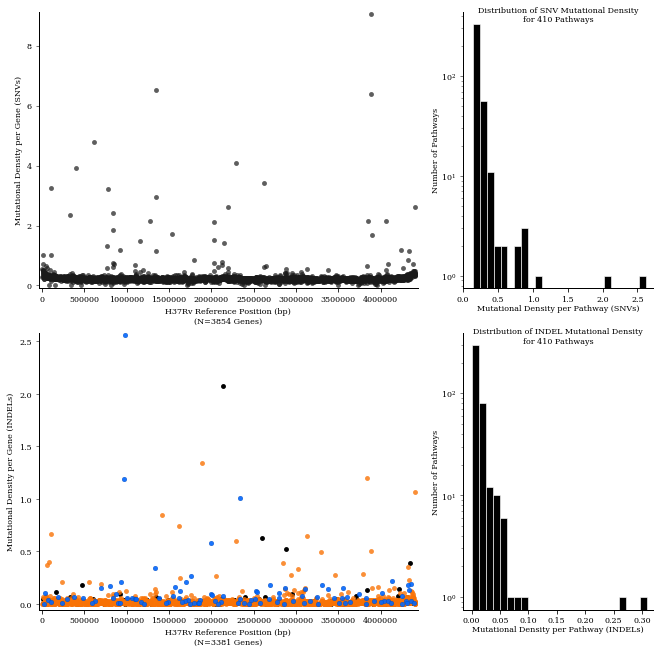

In [153]:
fig = plt.figure(constrained_layout=True)
spec = gridspec.GridSpec(ncols=2, nrows=2, figure=fig, width_ratios = [2,1])
spec.update(hspace=0.16) # set the spacing between axes. 
spec.update(wspace=0.16) # set the spacing between axes. 

axA = fig.add_subplot(spec[0,0])
axB = fig.add_subplot(spec[0,1])

axC = fig.add_subplot(spec[1,0])
axD = fig.add_subplot(spec[1,1])

SNV_mut_dens(axA)
SNV_mut_dens_pathway(axB)

INDEL_mut_dens(axC)
INDEL_mut_dens_pathway(axD)

fig = plt.gcf()
fig.set_size_inches(11.0, 11.0)
fig.tight_layout()

file_name = '/n/data1/hms/dbmi/farhat/Roger/homoplasy_project/Figures/for publication/mutational_event_dens_across_genes_and_pathways.pdf'
plt.savefig(file_name, bbox_inches='tight', dpi = 300 , transparent = True)

plt.show()